# Direct

In [1]:
import h5py
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

import argparse
import time

from eval_utils import compute_metrics

from utils import set_seed, flatten_configdict
from acquisition.acquirers import select, select_time

from omegaconf import OmegaConf
import hydra
import wandb


class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

class cfg:
    equation = 'KdV'
    
initial_time_steps = 416
device = 'cuda'
nt = 14

lr = 1e-3
epochs = 100
batch_size = 32

ensemble_size = 5

print('Loading training data...')
with h5py.File(f'data_large/{cfg.equation}_train_100000_default.h5', 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:100, :131], dtype=torch.float32, device=cfg.device)
# print('Loading validation data...')
# with h5py.File(f'data_large/{cfg.equation}_valid_1024_default.h5', 'r') as f:
#     Traj_dataset.traj_valid = torch.tensor(f['valid']['pde_140-256'][:, :131], dtype=torch.float32)
print('Loading test data...')
with h5py.File(f'data_large/{cfg.equation}_test_100000_default.h5', 'r') as f:
    # Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:, :131], dtype=torch.float32)
    Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:10000, :131], dtype=torch.float32)

def train(X, Y):
    model = FNO(n_modes=cfg.model.n_modes, hidden_channels=64,
                in_channels=1, out_channels=1)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X, Y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: {total_loss}')
    return model

def test(model, X_test, Y_test):
    # X_test = Traj_dataset.traj_test[:,0,:].unsqueeze(1).to(device)
    # Y_test = Traj_dataset.traj_test[:,-1,:].unsqueeze(1).to(device)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    model.eval()

    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            Y_test_pred.append(model(x))
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

def test_trajectory(model):
    X_test = Traj_dataset.traj_test[:,0].unsqueeze(1).to(device)
    Y_test = Traj_dataset.traj_test[:,timestep::timestep].to(device)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    model.eval()

    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            # print(y_pred.shape, y.shape)
            assert y_pred.shape == y.shape
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=2)

    return metrics

class direct_model(torch.nn.Module):
    def __init__(self, model, unrolling):
        super().__init__()
        self.model = model
        self.unrolling = unrolling
    def forward(self, x):
        for _ in range(self.unrolling):
            x = self.model(x)
        return x
    
class trajectory_model(torch.nn.Module):
    def __init__(self, model, unrolling):
        super().__init__()
        self.model = model
        self.unrolling = unrolling
    def forward(self, x):
        trajectory = []
        for _ in range(self.unrolling):
            x = self.model(x)
            trajectory.append(x)
        return torch.cat(trajectory, dim=1) # [cfg.train.batch_size, unrolling, nx]

timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
assert timestep == 10 # hardcoded for now (130/ (14-1) = 10)

X = Traj_dataset.traj_train[:,0].unsqueeze(1).to(device)
Y = Traj_dataset.traj_train[:,timestep].unsqueeze(1).to(device)

X_test = Traj_dataset.traj_test[:,0].unsqueeze(1).to(device)
Y_test = Traj_dataset.traj_test[:,timestep].unsqueeze(1).to(device)


Loading training data...
Loading test data...


In [2]:
ensemble = [train(X, Y) for _ in range(ensemble_size)]

Epoch 0: 4.842905443161726
Epoch 10: 0.058769970608409494
Epoch 20: 0.02199057213147171
Epoch 30: 0.005634777407976799
Epoch 40: 0.0035962737310910597
Epoch 50: 0.0027259289236098994
Epoch 60: 0.0013926598330726847
Epoch 70: 0.0009872408299997915
Epoch 80: 0.0008213012260966934
Epoch 90: 0.000742222138796933
Epoch 0: 5.004136279225349
Epoch 10: 0.02997107751434669
Epoch 20: 0.050876038148999214
Epoch 30: 0.005685930445906706
Epoch 40: 0.003160289110383019
Epoch 50: 0.002620735758682713
Epoch 60: 0.0014320179343485506
Epoch 70: 0.0010646953378454782
Epoch 80: 0.0008945687295636162
Epoch 90: 0.0008381326697417535
Epoch 0: 4.922620227560401
Epoch 10: 0.044042713358066976
Epoch 20: 0.020270533888833597
Epoch 30: 0.010359191277530044
Epoch 40: 0.006132716924184933
Epoch 50: 0.0031002151590655558
Epoch 60: 0.0016633002232993022
Epoch 70: 0.0011433121289883275
Epoch 80: 0.0010017741351475706
Epoch 90: 0.0009123379204538651
Epoch 0: 5.143617317080498
Epoch 10: 0.03953005705261603
Epoch 20: 0.0

In [3]:
metrics_list =  torch.stack([torch.stack(test(model, X_test, Y_test)) for model in ensemble]) # [ensemble_size, 3, datasize]
print(f'L2: {metrics_list[:, 0, :].mean().item()}, Relative L2: {metrics_list[:, 1, :].mean().item()}, MSE: {metrics_list[:, 2, :].mean().item()}')

L2: 0.3104230463504791, Relative L2: 0.021720245480537415, MSE: 0.004455200862139463


In [7]:
from matplotlib import pyplot as plt

with torch.no_grad():
    pred = torch.stack([torch.cat([model(x) for x in X_test.split(512)]) for model in ensemble]) # [ensemble_size, datasize, ...]

average_error = torch.mean(torch.mean((pred - Y_test.unsqueeze(0))**2, dim=tuple(range(2, pred.dim()))), dim=0)
single_error = torch.mean((pred - Y_test.unsqueeze(0))**2, dim=tuple(range(2, pred.dim())))[0]
mae = torch.mean(torch.mean(torch.abs(pred - Y_test.unsqueeze(0)), dim=tuple(range(2, pred.dim()))), dim=0)
error_mean = torch.mean((pred.mean(dim=0) - Y_test)**2, dim=tuple(range(1, pred.dim()-1)))

variance = torch.var(pred, dim=0).mean(dim=tuple(range(1, pred.dim()-1)))
std = torch.std(pred, dim=0).mean(dim=tuple(range(1, pred.dim()-1)))

average_error, variance = average_error.cpu().numpy(), variance.cpu().numpy()
single_error = single_error.cpu().numpy()
mae = mae.cpu().numpy()
std = std.cpu().numpy()
error_mean = error_mean.cpu().numpy()


Text(0, 0.5, 'Error Mean')

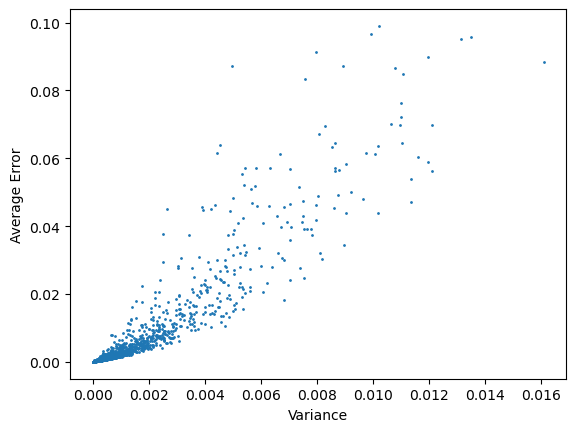

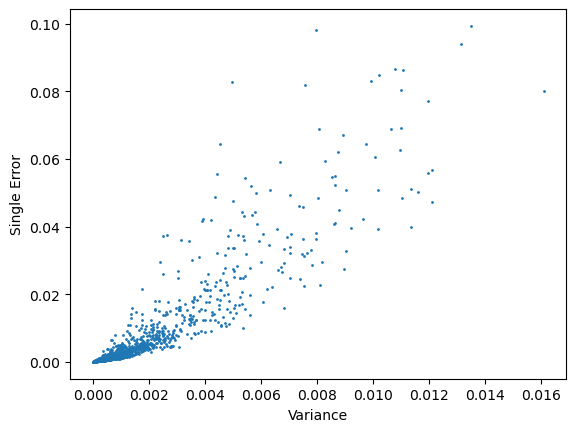

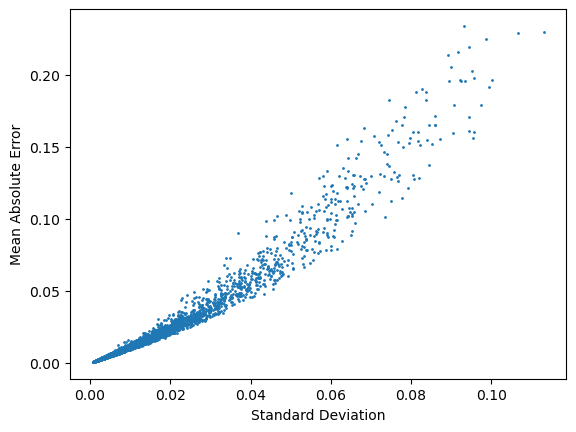

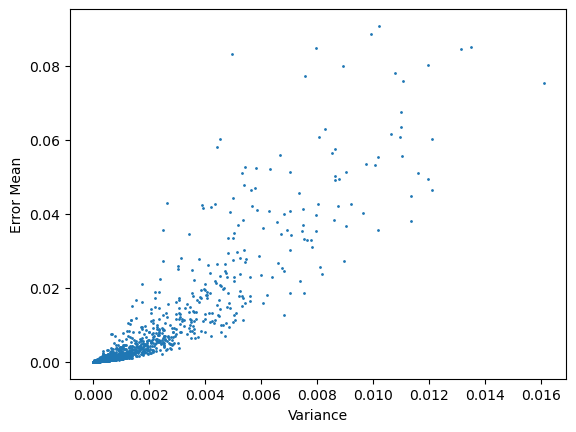

In [14]:
idx = average_error < 0.1
# idx = average_error < 100

plt.figure()
plt.scatter(variance[idx], average_error[idx], s=1)
plt.xlabel('Variance')
plt.ylabel('Average Error')

plt.figure()
plt.scatter(variance[idx], single_error[idx], s=1)
plt.xlabel('Variance')
plt.ylabel('Single Error')


plt.figure()
plt.scatter(std[idx], mae[idx], s=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Absolute Error')

plt.figure()
plt.scatter(variance[idx], error_mean[idx], s=1)
plt.xlabel('Variance')
plt.ylabel('Error Mean')


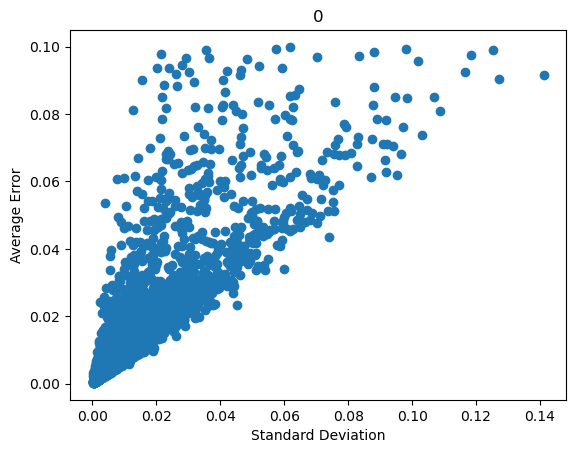

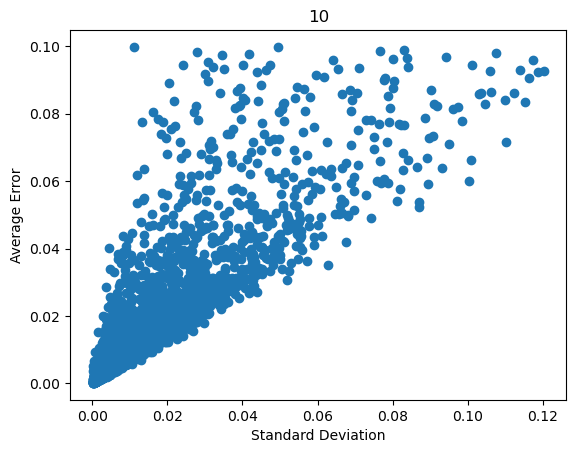

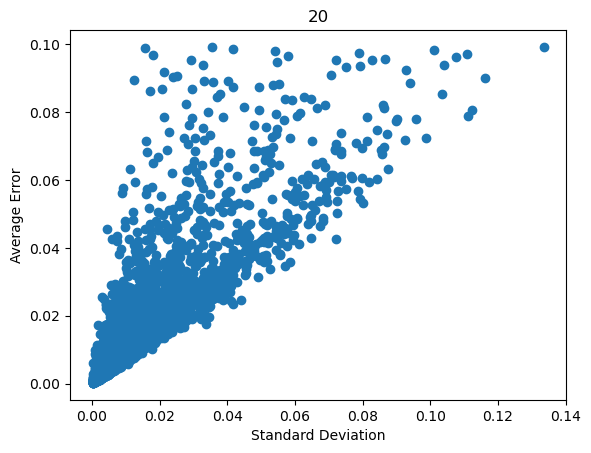

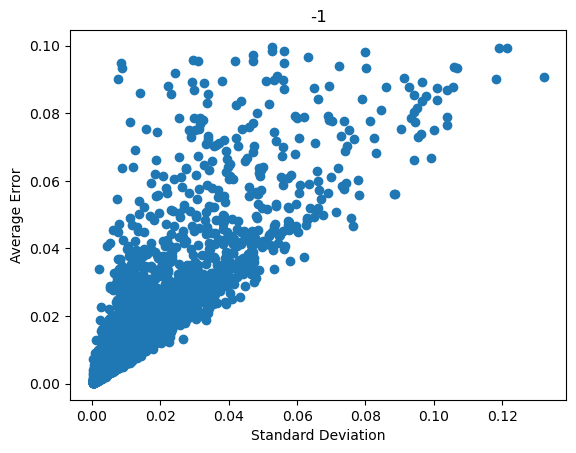

In [6]:
from matplotlib import pyplot as plt

for interest in [0, 10, 20, -1]:
    with torch.no_grad():
        pred = torch.stack([torch.cat([model(x) for x in X_test.split(512)]) for model in ensemble]) # [ensemble_size, datasize, ...]

    average_error = torch.mean(torch.abs(pred - Y_test.unsqueeze(0)), dim=0)

    std = torch.std(pred, dim=0)

    # average_error, std = average_error.flatten(), std.flatten()
    average_error, std = average_error[:,0,interest], std[:,0,interest]

    average_error, std = average_error.cpu().numpy(), std.cpu().numpy()

    idx = average_error < 0.1
    # idx = average_error < 100

    plt.figure()
    plt.scatter(std[idx], average_error[idx])
    plt.xlabel('Standard Deviation')
    plt.ylabel('Average Error')
    plt.title(interest)